In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 2aug.csv to 2aug.csv
Saving covid_with_y_values.csv to covid_with_y_values.csv


In [ ]:
import pandas as pd
import numpy as np
import io
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import accuracy_score,f1_score,precision_score,roc_auc_score,recall_score,confusion_matrix
from sklearn.model_selection import train_test_split
import graphviz


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['covid_with_y_values.csv']), usecols=range(3,30)) #remove 1st to third column

In [ ]:
df.head()

,Date,school_closures,international_travel_controls,restriction_gatherings,cancel_public_events,public_information_campaigns,restrictions_internal_movements,income_support,facial_coverings,vaccination_policy,testing_policy,contact_tracing,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,new_vaccinations_smoothed_per_million,population,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,international_travel_controls_binary,probability_open
0,1/6/2020,3,3,4,2,2,2,0,1,0,1,1,16.796,0.169,0,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,0,0.923077
1,8/6/2020,3,3,4,2,2,2,0,3,0,1,1,18.962,0.393,0,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,0,1.000000
2,15/6/2020,3,1,4,2,2,2,0,3,0,1,1,16.921,0.400,0,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,1.000000
3,22/6/2020,3,1,4,2,2,2,0,3,0,1,1,13.270,0.422,0,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,1.000000
4,29/6/2020,3,1,4,2,2,2,0,3,0,1,1,7.637,0.525,0,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,1.000000


## Select NA values for prediction and evaluation

In [ ]:
data_topredict = pd.read_csv(io.BytesIO(uploaded['covid_with_y_values.csv'])) 

In [ ]:
data_topredict = data_topredict[data_topredict["probability_open"].isna()] #to be used once model is done

In [ ]:
data_topredict.head()

,Unnamed: 0,Entity,Code,Date,school_closures,international_travel_controls,restriction_gatherings,cancel_public_events,public_information_campaigns,restrictions_internal_movements,income_support,facial_coverings,vaccination_policy,testing_policy,contact_tracing,new_cases_smoothed_per_million,new_deaths_smoothed_per_million,new_vaccinations_smoothed_per_million,population,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,international_travel_controls_binary,probability_open
45,45,Afghanistan,AFG,12/4/2021,0,1,0,2,1,0,0,2,2,3,0,1.927,0.077,169,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN
46,46,Afghanistan,AFG,19/4/2021,0,1,0,2,1,0,0,2,2,3,0,2.407,0.062,206,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN
47,47,Afghanistan,AFG,26/4/2021,0,1,0,2,1,0,0,2,2,3,0,4.099,0.169,292,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN
48,48,Afghanistan,AFG,3/5/2021,0,1,0,2,1,0,0,2,2,3,0,4.716,0.183,358,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN
49,49,Afghanistan,AFG,10/5/2021,0,1,0,2,1,0,0,3,2,3,1,6.470,0.206,358,38928341,54.422,18.6,2.581,1803.987,597.029,9.59,0.5,64.83,0.511,1,NaN


## Give data label for probability > 0.5

In [ ]:
df.dropna(inplace = True) #remove all the "to_predict"

In [ ]:
conditions = [(df["probability_open"] < 0.5), (df["probability_open"]>= 0.5)]
values = [0, 1]

df["label"] = np.select(conditions, values) #if else condition for label

In [ ]:
df.label.value_counts() #check for unbalanced dataset

0    3771
1    2754
Name: label, dtype: int64

## Dataset preparation for model training

In [ ]:
allcols = df.columns.tolist()
feature_cols = allcols.copy()
feature_cols.remove("probability_open") #remove due to multicollinearity
feature_cols.remove("label") #remove response variable
feature_cols.remove("Date") #remove date which is not a feature in the model

print(feature_cols)

['school_closures', 'international_travel_controls', 'restriction_gatherings', 'cancel_public_events', 'public_information_campaigns', 'restrictions_internal_movements', 'income_support', 'facial_coverings', 'vaccination_policy', 'testing_policy', 'contact_tracing', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 'new_vaccinations_smoothed_per_million', 'population', 'population_density', 'median_age', 'aged_65_older', 'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'international_travel_controls_binary']


In [ ]:
y = df["label"] #get response variable
x = df[feature_cols] #get features

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 3, stratify = y) #try to balance the dataset more

In [ ]:
y_train.value_counts() #training dataset is balanced at approximately 42% for y=1

0    3017
1    2203
Name: label, dtype: int64

In [ ]:
y_test.value_counts() #test dataset is balanced at approximately 42% for y=1

0    754
1    551
Name: label, dtype: int64

## Initial Model

In [ ]:
def feature_imp(model):
    a=dict(zip(X_train.columns, model.feature_importances_.round(3)))
    b = dict()
    for key, value in a.items():
        if value > 0 :
            b[key] = value

    return sorted(b.items(), key=lambda x: x[1],reverse=True)

In [ ]:
# normal fitting
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

<BarContainer object of 25 artists>

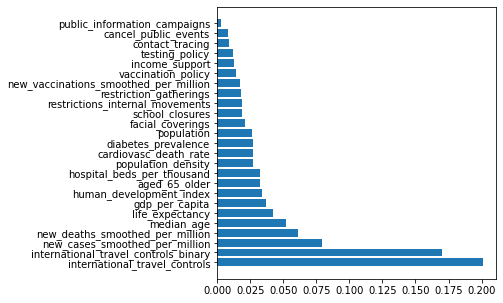

In [ ]:
plt.figure(figsize=(5,5))
imp = feature_imp(clf)
x_val = [x[0] for x in imp]
y_val = [x[1] for x in imp]
plt.barh(x_val,y_val)

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_pred_train, y_train))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy (Training Set):",round(accuracy_score(y_train, y_pred_train),4))
print('Precision (Training Set):', round(precision_score(y_train, y_pred_train),4))
print('Specificity (Training Set):', round(specificity,4))
print('Sensitivity (Training Set):',round(recall_score(y_train,y_pred_train),4))
print('F1-Score (Training Set):', round(f1_score(y_train,y_pred_train),4))
print('AUC (Training Set):',round(roc_auc_score(y_train, y_pred_train),4))
feature_imp(clf)

,True Y=0,True Y=1
Predicted Y=0,3013,3
Predicted Y=1,4,2200


Accuracy (Training Set): 0.9987
Precision (Training Set): 0.9982
Specificity (Training Set): 0.9987
Sensitivity (Training Set): 0.9986
F1-Score (Training Set): 0.9984
AUC (Training Set): 0.9987


[('international_travel_controls', 0.201),
 ('international_travel_controls_binary', 0.17),
 ('new_cases_smoothed_per_million', 0.079),
 ('new_deaths_smoothed_per_million', 0.061),
 ('median_age', 0.052),
 ('life_expectancy', 0.042),
 ('gdp_per_capita', 0.037),
 ('human_development_index', 0.034),
 ('aged_65_older', 0.032),
 ('hospital_beds_per_thousand', 0.032),
 ('population_density', 0.027),
 ('cardiovasc_death_rate', 0.027),
 ('diabetes_prevalence', 0.027),
 ('population', 0.026),
 ('facial_coverings', 0.021),
 ('school_closures', 0.019),
 ('restrictions_internal_movements', 0.019),
 ('restriction_gatherings', 0.018),
 ('new_vaccinations_smoothed_per_million', 0.017),
 ('vaccination_policy', 0.014),
 ('income_support', 0.013),
 ('testing_policy', 0.012),
 ('contact_tracing', 0.009),
 ('cancel_public_events', 0.008),
 ('public_information_campaigns', 0.003)]

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy (Testing Set):",round(accuracy_score(y_test, y_pred),4))
print('Precision (Testing Set):', round(precision_score(y_test, y_pred),4))
print('Specificity (Testing Set):', round(specificity,4))
print('Sensitivity (Testing Set):',round(recall_score(y_test,y_pred),4))
print('F1-Score (Testing Set):', round(f1_score(y_test,y_pred),4))
print('AUC (Testing Set):',round(roc_auc_score(y_test, y_pred),4))
feature_imp(clf)

,True Y=0,True Y=1
Predicted Y=0,727,40
Predicted Y=1,27,511


Accuracy (Testing Set): 0.9487
Precision (Testing Set): 0.9498
Specificity (Testing Set): 0.9642
Sensitivity (Testing Set): 0.9274
F1-Score (Testing Set): 0.9385
AUC (Testing Set): 0.9458


[('international_travel_controls', 0.201),
 ('international_travel_controls_binary', 0.17),
 ('new_cases_smoothed_per_million', 0.079),
 ('new_deaths_smoothed_per_million', 0.061),
 ('median_age', 0.052),
 ('life_expectancy', 0.042),
 ('gdp_per_capita', 0.037),
 ('human_development_index', 0.034),
 ('aged_65_older', 0.032),
 ('hospital_beds_per_thousand', 0.032),
 ('population_density', 0.027),
 ('cardiovasc_death_rate', 0.027),
 ('diabetes_prevalence', 0.027),
 ('population', 0.026),
 ('facial_coverings', 0.021),
 ('school_closures', 0.019),
 ('restrictions_internal_movements', 0.019),
 ('restriction_gatherings', 0.018),
 ('new_vaccinations_smoothed_per_million', 0.017),
 ('vaccination_policy', 0.014),
 ('income_support', 0.013),
 ('testing_policy', 0.012),
 ('contact_tracing', 0.009),
 ('cancel_public_events', 0.008),
 ('public_information_campaigns', 0.003)]

## Remove insignificant variables

In [ ]:
feature_cols.remove("public_information_campaigns")
y = df["label"]
x = df[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 3, stratify = y)

In [ ]:
# model after removing insignificant variables
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred = clf.predict(X_test)

<BarContainer object of 24 artists>

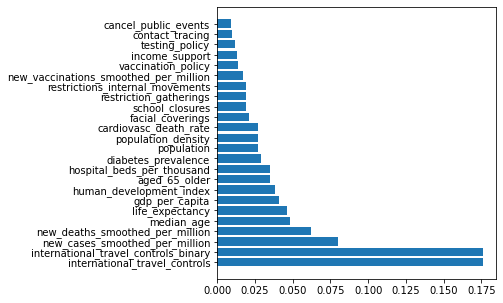

In [ ]:
plt.figure(figsize=(5,5))
imp = feature_imp(clf)
x_val = [x[0] for x in imp]
y_val = [x[1] for x in imp]
plt.barh(x_val,y_val)

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_pred_train, y_train))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy (Training Set):",round(accuracy_score(y_train, y_pred_train),4))
print('Precision (Training Set):', round(precision_score(y_train, y_pred_train),4))
print('Specificity (Training Set):', round(specificity,4))
print('Sensitivity (Training Set):',round(recall_score(y_train,y_pred_train),4))
print('F1-Score (Training Set):', round(f1_score(y_train,y_pred_train),4))
print('AUC (Training Set):',round(roc_auc_score(y_train, y_pred_train),4))
feature_imp(clf)

,True Y=0,True Y=1
Predicted Y=0,3013,3
Predicted Y=1,4,2200


Accuracy (Training Set): 0.9987
Precision (Training Set): 0.9982
Specificity (Training Set): 0.9987
Sensitivity (Training Set): 0.9986
F1-Score (Training Set): 0.9984
AUC (Training Set): 0.9987


[('international_travel_controls', 0.176),
 ('international_travel_controls_binary', 0.176),
 ('new_cases_smoothed_per_million', 0.08),
 ('new_deaths_smoothed_per_million', 0.062),
 ('median_age', 0.048),
 ('life_expectancy', 0.046),
 ('gdp_per_capita', 0.041),
 ('human_development_index', 0.038),
 ('aged_65_older', 0.035),
 ('hospital_beds_per_thousand', 0.035),
 ('diabetes_prevalence', 0.029),
 ('population', 0.027),
 ('population_density', 0.027),
 ('cardiovasc_death_rate', 0.027),
 ('facial_coverings', 0.021),
 ('school_closures', 0.019),
 ('restriction_gatherings', 0.019),
 ('restrictions_internal_movements', 0.019),
 ('new_vaccinations_smoothed_per_million', 0.017),
 ('vaccination_policy', 0.014),
 ('income_support', 0.013),
 ('testing_policy', 0.012),
 ('contact_tracing', 0.01),
 ('cancel_public_events', 0.009)]

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_pred, y_test))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy (Testing Set):",round(accuracy_score(y_test, y_pred),4))
print('Precision (Testing Set):', round(precision_score(y_test, y_pred),4))
print('Specificity (Testing Set):', round(specificity,4))
print('Sensitivity (Testing Set):',round(recall_score(y_test,y_pred),4))
print('F1-Score (Testing Set):', round(f1_score(y_test,y_pred),4))
print('AUC (Testing Set):',round(roc_auc_score(y_test, y_pred),4))
feature_imp(clf)

,True Y=0,True Y=1
Predicted Y=0,731,39
Predicted Y=1,23,512


Accuracy (Testing Set): 0.9525
Precision (Testing Set): 0.957
Specificity (Testing Set): 0.9695
Sensitivity (Testing Set): 0.9292
F1-Score (Testing Set): 0.9429
AUC (Testing Set): 0.9494


[('international_travel_controls', 0.176),
 ('international_travel_controls_binary', 0.176),
 ('new_cases_smoothed_per_million', 0.08),
 ('new_deaths_smoothed_per_million', 0.062),
 ('median_age', 0.048),
 ('life_expectancy', 0.046),
 ('gdp_per_capita', 0.041),
 ('human_development_index', 0.038),
 ('aged_65_older', 0.035),
 ('hospital_beds_per_thousand', 0.035),
 ('diabetes_prevalence', 0.029),
 ('population', 0.027),
 ('population_density', 0.027),
 ('cardiovasc_death_rate', 0.027),
 ('facial_coverings', 0.021),
 ('school_closures', 0.019),
 ('restriction_gatherings', 0.019),
 ('restrictions_internal_movements', 0.019),
 ('new_vaccinations_smoothed_per_million', 0.017),
 ('vaccination_policy', 0.014),
 ('income_support', 0.013),
 ('testing_policy', 0.012),
 ('contact_tracing', 0.01),
 ('cancel_public_events', 0.009)]

## Random Forest Tuning

In [ ]:
#Tune on the max_depth parameter, on both 'gini' and 'entropy' 

max_depth = []
acc_gini = []
acc_entropy = []
for i in range(15,25):
    dtree = RandomForestClassifier(n_estimators=500, random_state=0, criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
    ###
    dtree = RandomForestClassifier(n_estimators=500, random_state=0, criterion='entropy', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
    'acc_entropy':pd.Series(acc_entropy),
    'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
# plt.plot('max_depth','acc_gini', data=d, label='gini')
# plt.plot('max_depth','acc_entropy', data=d, label='entropy')
# plt.xlabel('max_depth')
# plt.ylabel('accuracy')
# plt.legend()
print("Best max_depth for gini:", d.sort_values('acc_gini',ascending=False).iloc[0,2])
print("Best max_depth for entropy:", d.sort_values('acc_entropy',ascending=False).iloc[0,2])

Best max_depth for gini: 23
Best max_depth for entropy: 18


In [ ]:
#Tune on max_features parameter, on both 'gini' and 'entropy' 

max_depth = []
acc_gini = []
acc_entropy = []
for i in range(2, 15):
    dtree = RandomForestClassifier(n_estimators=500, random_state=0, criterion='gini', max_depth=23, max_features=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))
    ###
    dtree = RandomForestClassifier(n_estimators=500, random_state=0, criterion='entropy', max_depth=18, max_features=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))
    ####
    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
    'acc_entropy':pd.Series(acc_entropy),
    'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
# plt.plot('max_depth','acc_gini', data=d, label='gini')
# plt.plot('max_depth','acc_entropy', data=d, label='entropy')
# plt.xlabel('max_depth')
# plt.ylabel('accuracy')
# plt.legend()
print("Best max_features for gini:", d.sort_values('acc_gini',ascending=False).iloc[0,2])
print("Best max_features for entropy:", d.sort_values('acc_entropy',ascending=False).iloc[0,2])

Best max_features for gini: 2
Best max_features for entropy: 11


In [ ]:
# Model with criterion='gini', max_depth=23, max_features=2

clf_gini = RandomForestClassifier(n_estimators=500, random_state=0, criterion='gini', max_depth=23, max_features=2)
clf_gini = clf_gini.fit(X_train,y_train)
y_pred_gini = clf_gini.predict(X_test)
y_pred_train_gini = clf_gini.predict(X_train)
cm = pd.DataFrame(confusion_matrix(y_pred_train_gini, y_train))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy (Training Set):",round(accuracy_score(y_train, y_pred_train_gini),4))
print('Precision (Training Set):', round(precision_score(y_train, y_pred_train_gini),4))
print('Specificity (Training Set):', round(specificity,4))
print('Recall (Training Set):',round(recall_score(y_train,y_pred_train_gini),4))
print('F1-Score (Training Set):', round(f1_score(y_train,y_pred_train_gini),4))
print('AUC (Training Set):',round(roc_auc_score(y_train, y_pred_train_gini),4))
cm2 = pd.DataFrame(confusion_matrix(y_pred_gini, y_test))
cm2.columns = ['True Y=0','True Y=1']
cm2.index = ['Predicted Y=0','Predicted Y=1']
display(cm2)
specificity2 = cm2.iloc[0, 0]/(cm2.iloc[0, 0] + cm2.iloc[1, 0])
print("Accuracy (Testing Set):", round(accuracy_score(y_test, y_pred_gini),4))
print('Precision (Testing Set):', round(precision_score(y_test, y_pred_gini),4))
print('Specificity (Testing Set):', round(specificity2,4))
print('Sensitivity (Testing Set):', round(recall_score(y_test,y_pred_gini),4))
print('F1-Score (Testing Set):',  round(f1_score(y_test,y_pred_gini),4))
print('AUC (Testing Set):', round(roc_auc_score(y_test, y_pred_gini),4))

,True Y=0,True Y=1
Predicted Y=0,3013,3
Predicted Y=1,4,2200


Accuracy (Training Set): 0.9987
Precision (Training Set): 0.9982
Specificity (Training Set): 0.9987
Recall (Training Set): 0.9986
F1-Score (Training Set): 0.9984
AUC (Training Set): 0.9987


,True Y=0,True Y=1
Predicted Y=0,733,39
Predicted Y=1,21,512


Accuracy (Testing Set): 0.954
Precision (Testing Set): 0.9606
Specificity (Testing Set): 0.9721
Sensitivity (Testing Set): 0.9292
F1-Score (Testing Set): 0.9446
AUC (Testing Set): 0.9507


In [ ]:
# Model with criterion='entropy', max_depth=18, max_features=11

clf_en = RandomForestClassifier(n_estimators=500, random_state=0, criterion='entropy', max_depth=18, max_features=11)
clf_en = clf_en.fit(X_train,y_train)
y_pred_en = clf_en.predict(X_test)
y_pred_train_en = clf_en.predict(X_train)
cm = pd.DataFrame(confusion_matrix(y_pred_train_en, y_train))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy (Training Set):",round(accuracy_score(y_train, y_pred_train_en),4))
print('Precision (Training Set):', round(precision_score(y_train, y_pred_train_en),4))
print('Specificity (Training Set):', round(specificity,4))
print('Recall (Training Set):',round(recall_score(y_train,y_pred_train_en),4))
print('F1-Score (Training Set):', round(f1_score(y_train,y_pred_train_en),4))
print('AUC (Training Set):',round(roc_auc_score(y_train, y_pred_train_en),4))
cm2 = pd.DataFrame(confusion_matrix(y_pred_en, y_test))
cm2.columns = ['True Y=0','True Y=1']
cm2.index = ['Predicted Y=0','Predicted Y=1']
display(cm2)
specificity2 = cm2.iloc[0, 0]/(cm2.iloc[0, 0] + cm2.iloc[1, 0])
print("Accuracy (Testing Set):", round(accuracy_score(y_test, y_pred_en),4))
print('Precision (Testing Set):', round(precision_score(y_test, y_pred_en),4))
print('Specificity (Testing Set):', round(specificity2,4))
print('Sensitivity (Testing Set):', round(recall_score(y_test,y_pred_en),4))
print('F1-Score (Testing Set):',  round(f1_score(y_test,y_pred_en),4))
print('AUC (Testing Set):', round(roc_auc_score(y_test, y_pred_en),4))

,True Y=0,True Y=1
Predicted Y=0,3013,3
Predicted Y=1,4,2200


Accuracy (Training Set): 0.9987
Precision (Training Set): 0.9982
Specificity (Training Set): 0.9987
Recall (Training Set): 0.9986
F1-Score (Training Set): 0.9984
AUC (Training Set): 0.9987


,True Y=0,True Y=1
Predicted Y=0,727,34
Predicted Y=1,27,517


Accuracy (Testing Set): 0.9533
Precision (Testing Set): 0.9504
Specificity (Testing Set): 0.9642
Sensitivity (Testing Set): 0.9383
F1-Score (Testing Set): 0.9443
AUC (Testing Set): 0.9512


## Random Forest (Model 2)

In [ ]:
# Concluded that the model with criterion='gini', max_depth=23, max_features=2 performs better
clf2 = RandomForestClassifier(n_estimators=500, random_state=0, criterion='gini', max_depth=23, max_features=2)
clf2 = clf2.fit(X_train,y_train)
y_pred2 = clf2.predict(X_test)
y_pred_train2 = clf2.predict(X_train)

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_pred_train2, y_train))
cm.columns = ['True Y=0','True Y=1']
cm.index = ['Predicted Y=0','Predicted Y=1']
display(cm)
specificity = cm.iloc[0, 0]/(cm.iloc[0, 0] + cm.iloc[1, 0])
print("Accuracy (Training Set):",round(accuracy_score(y_train, y_pred_train),4))
print('Precision (Training Set):', round(precision_score(y_train, y_pred_train),4))
print('Specificity (Training Set):', round(specificity,4))
print('Recall (Training Set):',round(recall_score(y_train,y_pred_train),4))
print('F1-Score (Training Set):', round(f1_score(y_train,y_pred_train),4))
print('AUC (Training Set):',round(roc_auc_score(y_train, y_pred_train),4))
feature_imp(clf2)

,True Y=0,True Y=1
Predicted Y=0,3013,3
Predicted Y=1,4,2200


Accuracy (Training Set): 0.9987
Precision (Training Set): 0.9982
Specificity (Training Set): 0.9987
Recall (Training Set): 0.9986
F1-Score (Training Set): 0.9984
AUC (Training Set): 0.9987


[('international_travel_controls', 0.152),
 ('international_travel_controls_binary', 0.131),
 ('new_cases_smoothed_per_million', 0.081),
 ('new_deaths_smoothed_per_million', 0.064),
 ('life_expectancy', 0.049),
 ('median_age', 0.048),
 ('human_development_index', 0.046),
 ('gdp_per_capita', 0.044),
 ('hospital_beds_per_thousand', 0.041),
 ('aged_65_older', 0.04),
 ('diabetes_prevalence', 0.037),
 ('cardiovasc_death_rate', 0.034),
 ('population', 0.032),
 ('population_density', 0.032),
 ('facial_coverings', 0.024),
 ('restrictions_internal_movements', 0.022),
 ('school_closures', 0.021),
 ('restriction_gatherings', 0.02),
 ('income_support', 0.017),
 ('new_vaccinations_smoothed_per_million', 0.016),
 ('vaccination_policy', 0.014),
 ('testing_policy', 0.014),
 ('cancel_public_events', 0.011),
 ('contact_tracing', 0.011)]

In [ ]:
cm2 = pd.DataFrame(confusion_matrix(y_pred2, y_test))
cm2.columns = ['True Y=0','True Y=1']
cm2.index = ['Predicted Y=0','Predicted Y=1']
display(cm2)
specificity2 = cm2.iloc[0, 0]/(cm2.iloc[0, 0] + cm2.iloc[1, 0])
print("Accuracy (Testing Set):", round(accuracy_score(y_test, y_pred2),4))
print('Precision (Testing Set):', round(precision_score(y_test, y_pred2),4))
print('Specificity (Testing Set):', round(specificity2,4))
print('Sensitivity (Testing Set):', round(recall_score(y_test,y_pred2),4))
print('F1-Score (Testing Set):',  round(f1_score(y_test,y_pred2),4))
print('AUC (Testing Set):', round(roc_auc_score(y_test, y_pred2),4))
feature_imp(clf2)

,True Y=0,True Y=1
Predicted Y=0,733,39
Predicted Y=1,21,512


Accuracy (Testing Set): 0.954
Precision (Testing Set): 0.9606
Specificity (Testing Set): 0.9721
Sensitivity (Testing Set): 0.9292
F1-Score (Testing Set): 0.9446
AUC (Testing Set): 0.9507


[('international_travel_controls', 0.152),
 ('international_travel_controls_binary', 0.131),
 ('new_cases_smoothed_per_million', 0.081),
 ('new_deaths_smoothed_per_million', 0.064),
 ('life_expectancy', 0.049),
 ('median_age', 0.048),
 ('human_development_index', 0.046),
 ('gdp_per_capita', 0.044),
 ('hospital_beds_per_thousand', 0.041),
 ('aged_65_older', 0.04),
 ('diabetes_prevalence', 0.037),
 ('cardiovasc_death_rate', 0.034),
 ('population', 0.032),
 ('population_density', 0.032),
 ('facial_coverings', 0.024),
 ('restrictions_internal_movements', 0.022),
 ('school_closures', 0.021),
 ('restriction_gatherings', 0.02),
 ('income_support', 0.017),
 ('new_vaccinations_smoothed_per_million', 0.016),
 ('vaccination_policy', 0.014),
 ('testing_policy', 0.014),
 ('cancel_public_events', 0.011),
 ('contact_tracing', 0.011)]

## Random Forest (Predictions)

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['2aug.csv']), usecols=range(3,29)) #remove 1st to third column
allcols = df.columns.tolist()
feature_cols = allcols.copy()
feature_cols.remove("Date")
feature_cols.remove("public_information_campaigns")

x = df[feature_cols]
feature_cols

['school_closures',
 'international_travel_controls',
 'restriction_gatherings',
 'cancel_public_events',
 'restrictions_internal_movements',
 'income_support',
 'facial_coverings',
 'vaccination_policy',
 'testing_policy',
 'contact_tracing',
 'new_cases_smoothed_per_million',
 'new_deaths_smoothed_per_million',
 'new_vaccinations_smoothed_per_million',
 'population',
 'population_density',
 'median_age',
 'aged_65_older',
 'gdp_per_capita',
 'cardiovasc_death_rate',
 'diabetes_prevalence',
 'hospital_beds_per_thousand',
 'life_expectancy',
 'human_development_index',
 'international_travel_controls_binary']

In [ ]:
y_pred_aug = clf2.predict(x)
y_pred_aug

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1])

In [ ]:
countries = pd.read_csv(io.BytesIO(uploaded['2aug.csv']))['Entity']
x['country'] = countries
x['prediction'] = y_pred_aug
predictions = x[['country', 'prediction']]
predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,country,prediction
0,Afghanistan,1
1,Albania,1
2,Argentina,0
3,Australia,0
4,Austria,0
...,...,...
127,Uzbekistan,0
128,Venezuela,0
129,Vietnam,0
130,Zambia,1


In [ ]:
predictions.to_csv('2augpred.csv')